In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
theta = (0.25, 0.1) # γ, λ
T = 30
t = np.arange(T)
P0 = 1.0

In [3]:
def simulate(P, t, γ, λ):
    om = 2.0*np.pi/365.0
    return γ *(1+np.sin(om*t))*P - λ*P**2

#x = odeint(simulate, P0, tobs, args=theta)[:,0]

In [4]:
def loglike(theta,obs):
    # step 1: run the model given the parameters to get state
    tobs = obs['t']
    yobs = obs['y']
    
    P = 2.5
    xhat = odeint(simulate, P, tobs, args=theta)[:,0]
    
    # step 2: compute the likelihood (compare state to observations)
    return -np.sum((yobs-xhat)**2)

### load in some (synthetic) observations

In [6]:
datafile = 'data/obs.csv'

data = np.loadtxt(datafile, skiprows=1, delimiter=',')

obs = {
    't':data[:,0],
    'y':data[:,1],
}

### The M-H MCMC algorithm

In [12]:
# setup
nc = 5000 # number of iterations (length of the chain)
theta_acc = np.full((nc,2), fill_value=np.nan) # accumulator for sample (parameter posterior)

thetaold = (0.2, 0.1) # initial condition for chain (parameter values)

# priors (use uniforms so set upper and lower bounds)
gam_low = 0.2
gam_up = 0.3
lam_low = 0.09
lam_up = 0.11

for ic in range(nc):
    # Step 1: Generate Trial Candidate (draw from parameter prior)
    gammac = np.random.uniform(low=gam_low, high=gam_up)
    lambdac = np.random.uniform(low=lam_low, high=lam_up)
    thetac = (gammac,lambdac)

    # Step 2: Compute acceptance probability for this candidate
    # compute log likelihood for candidate
    like_num = loglike(thetac,obs)

    # compute log likelihood for last member of chain (last sample member)
    like_denom = loglike(thetaold,obs)

    # compute the likelihood ratio
    likeratio = np.exp(like_num - like_denom)

    # determine acceptance probability
    A = min(1.0,likeratio) 

    # Step 3: Choose whether or not to accept candidate
    # accept candidate with probability A, otherwise revert to previous chain member
    if np.random.uniform() <= A:
        thetanew = thetac
    else:
        thetanew = thetaold

    # add to the sample 
    theta_acc[ic,:] = thetanew
    thetaold = thetanew

### plot the results

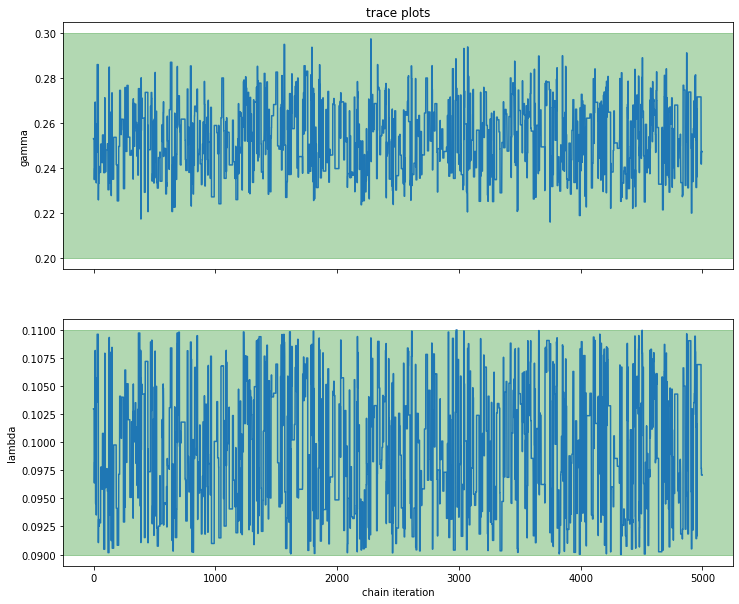

In [13]:
import matplotlib.pyplot as plt

# trace plots

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))
axs[0].plot(theta_acc[:,0])
axs[0].axhspan(gam_low, gam_up, color='green', alpha=0.3)
axs[0].set(ylabel='gamma', title='trace plots')
axs[1].plot(theta_acc[:,1])
axs[1].axhspan(lam_low, lam_up, color='green', alpha=0.3)
axs[1].set(ylabel='lambda', xlabel='chain iteration')
None

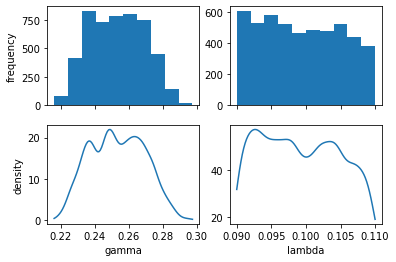

In [14]:
# histogram and kernel smooth density of posterior
import scipy.stats

fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col')
for icol,name in enumerate(('gamma','lambda')):
    # histogram
    axs[0,icol].hist(theta_acc[:,icol])
    # kernel smooth density
    ksd = scipy.stats.gaussian_kde(theta_acc[:,icol])
    x = np.linspace(np.min(theta_acc[:,icol]),np.max(theta_acc[:,icol]),100)
    axs[1,icol].plot(x,ksd(x))
    axs[1,icol].set_xlabel(name)
    if icol == 0:
        axs[0,icol].set_ylabel('frequency')
        axs[1,icol].set_ylabel('density')


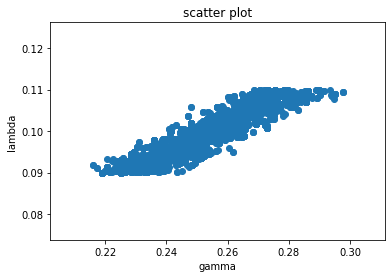

In [15]:
# scatter plot of joint distribution
fig, ax = plt.subplots()
ax.scatter(theta_acc[:,0], theta_acc[:,1])
ax.set(title='scatter plot', xlabel='gamma', ylabel='lambda')
None